In [2]:
import sys
sys.path.insert(0, '/users/ankushroy/iris/src')
print(sys.path)

['/users/ankushroy/iris/src', '/users/ankushroy/iris/src/models/tokenizer', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python38.zip', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8/lib-dynload', '', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8/site-packages']


In [3]:
from dataclasses import dataclass
from typing import Any, Tuple

from einops import rearrange
import torch
import torch.nn as nn

#from dataset import Batch
from lpips import LPIPS
from nets import Encoder, Decoder
from utils import LossWithIntermediateLosses

batch=1
@dataclass
class TokenizerEncoderOutput:
    z: torch.FloatTensor
    z_quantized: torch.FloatTensor
    tokens: torch.LongTensor


class Tokenizer(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, encoder: Encoder, decoder: Decoder, with_lpips: bool) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.encoder = encoder
        self.pre_quant_conv = torch.nn.Conv2d(encoder.config.z_channels, embed_dim, 1)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, decoder.config.z_channels, 1)
        self.decoder = decoder
        self.embedding.weight.data.uniform_(-1.0 / vocab_size, 1.0 / vocab_size)
        self.lpips = LPIPS().eval() if with_lpips else None

    def __repr__(self) -> str:
        return "tokenizer"

    def forward(self, x: torch.Tensor, should_preprocess: bool = False, should_postprocess: bool = False) -> Tuple[torch.Tensor]:
        outputs = self.encode(x, should_preprocess)
        decoder_input = outputs.z + (outputs.z_quantized - outputs.z).detach()
        reconstructions = self.decode(decoder_input, should_postprocess)
        return outputs.z, outputs.z_quantized, reconstructions

    def compute_loss(self, x, **kwargs: Any) -> LossWithIntermediateLosses:
        assert self.lpips is not None
        observations = x
        z, z_quantized, reconstructions = self(observations, should_preprocess=False, should_postprocess=False)

        # Codebook loss. Notes:
        # - beta position is different from taming and identical to original VQVAE paper
        # - VQVAE uses 0.25 by default
        beta = 1.0
        commitment_loss = (z.detach() - z_quantized).pow(2).mean() + beta * (z - z_quantized.detach()).pow(2).mean()

        reconstruction_loss = torch.abs(observations - reconstructions).mean()
        perceptual_loss = torch.mean(self.lpips(observations, reconstructions))

        return LossWithIntermediateLosses(commitment_loss=commitment_loss, reconstruction_loss=reconstruction_loss,perceptual_loss=perceptual_loss)

    def encode(self, x: torch.Tensor, should_preprocess: bool = False) -> TokenizerEncoderOutput:
        if should_preprocess:
            x = self.preprocess_input(x)
        #print("Shape of x:", x.shape)
        shape = x.shape  # (..., C, H, W)
        x = x.view(-1, *shape[-3:])
        #print("Shape of x as (x_view):", x.shape)
        z = self.encoder(x)
        #print("Shape of z:",z.shape)
        z = self.pre_quant_conv(z)
        b, e, h, w = z.shape
        z_flattened = rearrange(z, 'b e h w -> (b h w) e')
        #print("Shape of z_flattend:",z_flattened.shape)
        dist_to_embeddings = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1) - 2 * torch.matmul(z_flattened, self.embedding.weight.t())

        tokens = dist_to_embeddings.argmin(dim=-1)
        #print("Shape of tokens:",tokens.shape)
        z_q = rearrange(self.embedding(tokens), '(b h w) e -> b e h w', b=b, e=e, h=h, w=w).contiguous()
        #print("Shape of z_q:",z_q.shape)
        # Reshape to original
        z = z.reshape(*shape[:-3], *z.shape[1:])
        #print("Shape of reshaped z:", z.shape)
        z_q = z_q.reshape(*shape[:-3], *z_q.shape[1:])
        #print("Shape of reshaped z_q:", z_q.shape)
        tokens = tokens.reshape(*shape[:-3], -1)
        #print("Shape of tokens:", tokens.shape)

        return TokenizerEncoderOutput(z, z_q, tokens)

    def decode(self, z_q: torch.Tensor, should_postprocess: bool = False) -> torch.Tensor:
        shape = z_q.shape  # (..., E, h, w)
        z_q = z_q.view(-1, *shape[-3:])
        z_q = self.post_quant_conv(z_q)
        rec = self.decoder(z_q)
        rec = rec.reshape(*shape[:-3], *rec.shape[1:])
        if should_postprocess:
            rec = self.postprocess_output(rec)
        return rec

    @torch.no_grad()
    def encode_decode(self, x: torch.Tensor, should_preprocess: bool = False, should_postprocess: bool = False) -> torch.Tensor:
        z_q = self.encode(x, should_preprocess).z_quantized
        return self.decode(z_q, should_postprocess)

    def preprocess_input(self, x: torch.Tensor) -> torch.Tensor:
        """x is supposed to be channels first and in [0, 1]"""
        return x.mul(2).sub(1)

    def postprocess_output(self, y: torch.Tensor) -> torch.Tensor:
        """y is supposed to be channels first and in [-1, 1]"""
        return y.add(1).div(2)


In [4]:
from typing import List

import torch
import torch.nn as nn
## Configuration file for the Endocer and Decoder
@dataclass
class EncoderDecoderConfig:
    resolution: int
    in_channels: int
    z_channels: int
    ch: int
    ch_mult: List[int]
    num_res_blocks: int
    attn_resolutions: List[int]
    out_ch: int
    dropout: float

In [5]:
encoder = Encoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=256,
                                        ch=128,
                                        ch_mult= [1, 1, 2, 2, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [16],
                                        out_ch= 1,
                                        dropout= 0.0))
decoder=Decoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=256,
                                        ch=128,
                                        ch_mult= [1, 1, 2, 2, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [16],
                                        out_ch= 1,
                                        dropout= 0.0))
vocab_size = 1024 # actual vocabulary size 
embed_dim = 256  # the desired embedding dimension of the codebook (coebook dim)
tokenizer = Tokenizer(vocab_size, embed_dim, encoder, decoder, with_lpips=True)
print(encoder)
print(decoder)

Tokenizer : shape of latent is (256, 16, 16).
Encoder(
  (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0): Module(
      (block): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (attn): ModuleLi

In [ ]:
# encoder = Encoder(EncoderDecoderConfig(resolution=256,
#                                        in_channels=1,
#                                         z_channels=1024,
#                                         ch=64,
#                                         ch_mult= [1,1,1,1,1],
#                                         num_res_blocks= 2,
#                                         attn_resolutions= [8, 16],
#                                         out_ch= 1,
#                                         dropout= 0.0))
# decoder = Decoder(EncoderDecoderConfig(resolution=256,
#                                        in_channels=1,
#                                         z_channels=1024,
#                                         ch=64,
#                                         ch_mult= [1,1,1,1,1],
#                                         num_res_blocks= 2,
#                                         attn_resolutions= [8, 16],
#                                         out_ch= 1,
#                                         dropout= 0.0))
# vocab_size = 1024 # actual vocabulary size 
# embed_dim = 256 # the desired embedding dimension of the codebook (codebook dim) should be equal with the z_channels
# tokenizer = Tokenizer(vocab_size, embed_dim, encoder, decoder, with_lpips=True)
# print(encoder)
# print(decoder)

In [6]:
learning_rate=0.0001 # cfg training file 
optimizer_tokenizer = torch.optim.Adam(tokenizer.parameters(), lr=learning_rate)

In [7]:
# Define dataset
import torch
import sys
from nuwa_pytorch import VQGanVAE
import h5py
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
def eventGeneration(start_time, obs_time = 3 ,lead_time = 6, time_interval = 30):
    # Generate event based on starting time point, return a list: [[t-4,...,t-1,t], [t+1,...,t+72]]
    # Get the start year, month, day, hour, minute
    year = int(start_time[0:4])
    month = int(start_time[4:6])
    day = int(start_time[6:8])
    hour = int(start_time[8:10])
    minute = int(start_time[10:12])
    #print(datetime(year=year, month=month, day=day, hour=hour, minute=minute))
    times = [(datetime(year, month, day, hour, minute) + timedelta(minutes=time_interval * (x+1))) for x in range(lead_time)]
    lead = [dt.strftime('%Y%m%d%H%M') for dt in times]
    times = [(datetime(year, month, day, hour, minute) - timedelta(minutes=time_interval * x)) for x in range(obs_time)]
    obs = [dt.strftime('%Y%m%d%H%M') for dt in times]
    obs.reverse()
    return lead, obs

from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from torchvision.transforms import ToTensor, Compose, CenterCrop
class radarDataset(Dataset):
    def __init__(self, root_dir, event_times, obs_number = 3, pred_number = 6, transform=None):
        # event_times is an array of starting time t(string)
        # transform is the preprocessing functions
        self.root_dir = root_dir
        self.transform = transform
        self.event_times = event_times
        self.obs_number = obs_number
        self.pred_number = pred_number
    def __len__(self):
        return len(self.event_times)
    def __getitem__(self, idx):
        start_time = str(self.event_times[idx])
        time_list_pre, time_list_obs = eventGeneration(start_time, self.obs_number, self.pred_number)
        output = []
        time_list = time_list_obs + time_list_pre
        #print(time_list)
        for time in time_list:
            year = time[0:4]
            month = time[4:6]
            #path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAC_MFBS_EM_5min_' + time + '_NL.h5'
            path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAP_5min_' + time + '.h5'
            image = np.array(h5py.File(path)['image1']['image_data'])
            #image = np.ma.masked_where(image == 65535, image)
            image = image[264:520,242:498]
            image[image == 65535] = 0
            image = image.astype('float32')
            image = image/100*12
            image = np.clip(image, 0, 128)
            image = image/40
            #image = 2*image-1 #normalize to [-1,1]
            output.append(image)
        output = torch.permute(torch.tensor(np.array(output)), (1, 2, 0))
        output = self.transform(np.array(output))
        return output
#root_dir = '/users/hbi/data/RAD_NL25_RAC_MFBS_EM_5min/'
#dataset = radarDataset(root_dir, ["200808031600"], transform = Compose([ToTensor(),CenterCrop(256)]))
#print(image.shape)

In [8]:
# develop dataset
#from torch.cuda.amp import autocast
#from torch.autograd import Variable
import pandas as pd
root_dir = '/home/hbi/RAD_NL25_RAP_5min/' 
batch_size=1

df_train = pd.read_csv('/users/ankushroy/taming-transformers/training_Delfland08-14_20.csv', header = None)
event_times = df_train[0].to_list()
dataset_train = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_s = pd.read_csv('/users/ankushroy/taming-transformers/training_Delfland08-14.csv', header = None)
event_times = df_train_s[0].to_list()
dataset_train_del = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_test = pd.read_csv('/users/ankushroy/taming-transformers/testing_Delfland18-20.csv', header = None)
event_times = df_test[0].to_list()
dataset_test = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_vali = pd.read_csv('/users/ankushroy/taming-transformers/validation_Delfland15-17.csv', header = None)
event_times = df_vali[0].to_list()
dataset_vali = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_train_aa = pd.read_csv('/users/ankushroy/taming-transformers/training_Aa08-14.csv', header = None)
event_times = df_train_aa[0].to_list()
dataset_train_aa = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_dw = pd.read_csv('/users/ankushroy/taming-transformers/training_Dwar08-14.csv', header = None)
event_times = df_train_dw[0].to_list()
dataset_train_dw = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))    

df_train_re = pd.read_csv('/users/ankushroy/taming-transformers/training_Regge08-14.csv', header = None)
event_times = df_train_re[0].to_list()
dataset_train_re = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))   

data_list = [dataset_train_aa, dataset_train_dw, dataset_train_del, dataset_train_re]
train_aadedwre = torch.utils.data.ConcatDataset(data_list)

print(len(train_aadedwre), len(dataset_test), len(dataset_vali))
loaders = { 'train' :DataLoader(train_aadedwre, batch_size, shuffle=True, num_workers=8),
            'test' :DataLoader(dataset_test, batch_size, shuffle=False, num_workers=8), 
           'valid' :DataLoader(dataset_vali, batch_size, shuffle=False, num_workers=8),
          
          'train_aa5' :DataLoader(dataset_train_aa, batch_size, shuffle=False, num_workers=8),
          'train_dw5' :DataLoader(dataset_train_dw, batch_size, shuffle=False, num_workers=8),
          'train_del5' :DataLoader(dataset_train_del, batch_size, shuffle=True, num_workers=8),
          'train_re5' :DataLoader(dataset_train_re, batch_size, shuffle=False, num_workers=8),
          }

30632 3493 3560


In [9]:
# Initializing Device as cuda:0
cuda_version = torch.version.cuda
print("CUDA version:", cuda_version)
print(torch.cuda.is_available())
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
print("PyTorch version:", torch.__version__)

CUDA version: 11.3
True
cuda:1
PyTorch version: 1.11.0


In [ ]:
##Training loop VQVAE 
import numpy as np
from collections import defaultdict
loss_total_step=0.0
intermediate_losses = defaultdict(float)
num_epochs=80
device = torch.device("cuda:0")  # Specify the GPU device
epoch_start=0
tokenizer.to(device)
all_metrics = []  # List to store metrics for all epochs

for epoch in range(epoch_start,num_epochs):
    save_epoch = epoch in [0,2,4,9,19,29,39,49,59,79]
    #save_epoch = epoch in [2]
    loss_total_epoch=0.0
    optimizer_tokenizer.zero_grad()
    intermediate_losses = {}
    print("epoch {}".format(epoch))
    for i, images in enumerate(loaders['train']):
        loss_total_step=0.0
        image = images[0]
        image = image.unsqueeze(1)
        image = image[3:4, :, :, :]
        input_image= image.to(device)  # batch x
        #print(input_image.size())
        encoder_output = tokenizer.encode(input_image)
        losses=tokenizer.compute_loss(input_image)
        
        loss_total_step += losses.loss_total 
        loss_total_epoch += loss_total_step.item()/64
        if (i+1) % 64 == 0:
            (loss_total_step/64).backward()
            optimizer_tokenizer.step()
            optimizer_tokenizer.zero_grad()
            
            print("Losses: Total = {:.4f}".format(loss_total_step.item()))
            #loss_total_step=0.0
        

        for loss_name, loss_value in losses.intermediate_losses.items():
                intermediate_losses[f"{str(tokenizer)}/train/{loss_name}"] = loss_value/64
    
        
    metrics = {f'{str(Tokenizer)}/train/total_loss': loss_total_epoch, **intermediate_losses}
    print("Epoch {}: Total Loss = {:.4f}".format(epoch, metrics[f'{str(Tokenizer)}/train/total_loss']))

    if save_epoch:
        torch.save({
        'model_state_dict': tokenizer.state_dict(),
        'optimizer_state_dict': optimizer_tokenizer.state_dict(),
        }, '/space/ankushroy/Tokeniser_exp2_1024_embdim_8/vqvae_checkpoint_epoch{}'.format(epoch+1))

    all_metrics.append(metrics)  # Save metrics for the current epoch to the list


# Convert the metrics list to a NumPy array
metrics_array = np.array(all_metrics)

# Save the metrics array as a NumPy file
np.save('/space/ankushroy/Tokeniser_exp2_1024_embdim_8/metrices.npy', metrics_array)
# Print all errors from each epoch's metrics dictionary
# print(all_metrics)

MSE: 9.184 MAE: 0.697 PCC: 0.659 
 CSI(1mm): 0.526 CSI(2mm): 0.491 CSI(8mm): 0.306 
 ACC(1mm): 0.936 ACC(2mm): 0.955 ACC(8mm): 0.976 
 FSS(1km): 0.97 FSS(10km): 0.958 FSS(20km): 0.925 FSS(30km): 0.779


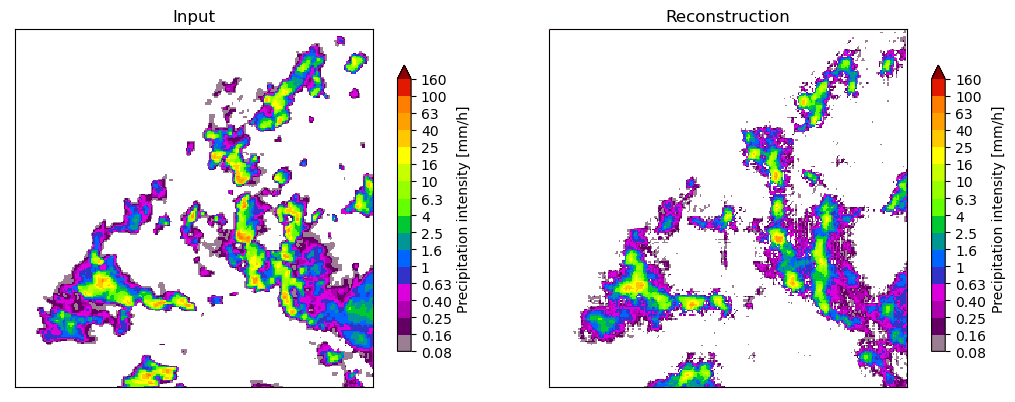

MSE: 10.139 MAE: 0.702 PCC: 0.643 
 CSI(1mm): 0.535 CSI(2mm): 0.483 CSI(8mm): 0.283 
 ACC(1mm): 0.935 ACC(2mm): 0.951 ACC(8mm): 0.975 
 FSS(1km): 0.956 FSS(10km): 0.943 FSS(20km): 0.91 FSS(30km): 0.765


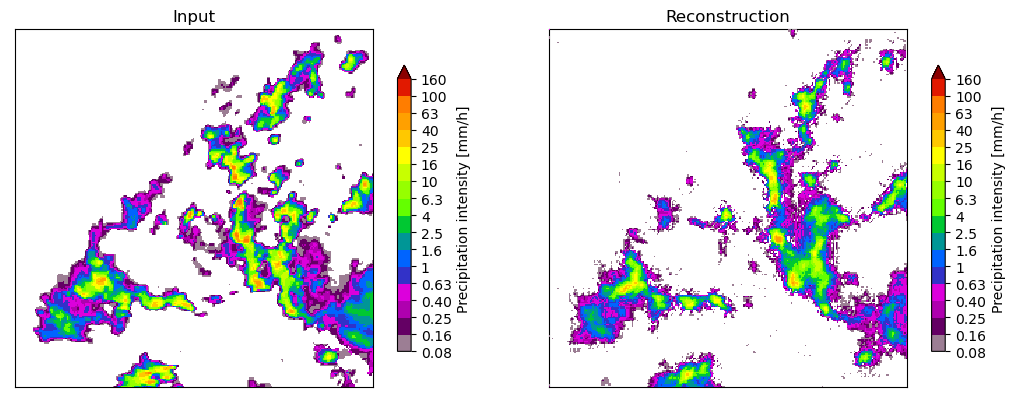

MSE: 1.016 MAE: 0.336 PCC: 0.771 
 CSI(1mm): 0.639 CSI(2mm): 0.558 CSI(8mm): 0.267 
 ACC(1mm): 0.932 ACC(2mm): 0.952 ACC(8mm): 0.993 
 FSS(1km): 0.982 FSS(10km): 0.974 FSS(20km): 0.955 FSS(30km): 0.871


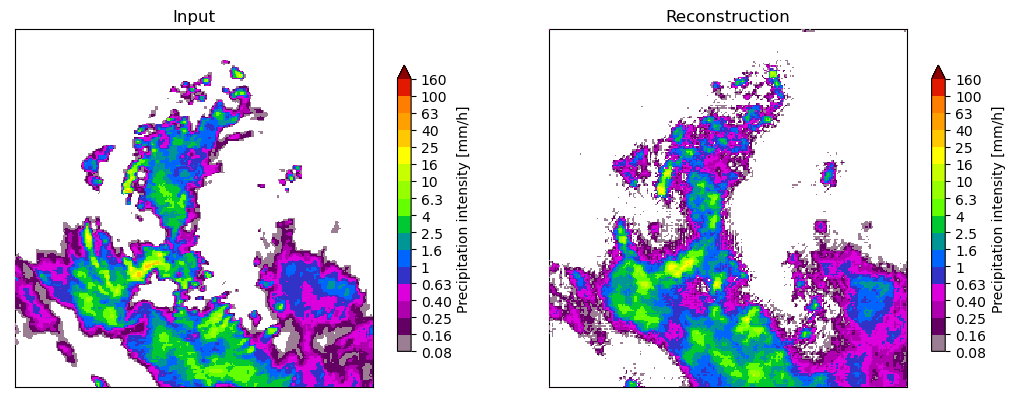

MSE: 9.237 MAE: 0.698 PCC: 0.727 
 CSI(1mm): 0.548 CSI(2mm): 0.497 CSI(8mm): 0.39 
 ACC(1mm): 0.934 ACC(2mm): 0.952 ACC(8mm): 0.978 
 FSS(1km): 0.962 FSS(10km): 0.949 FSS(20km): 0.914 FSS(30km): 0.767


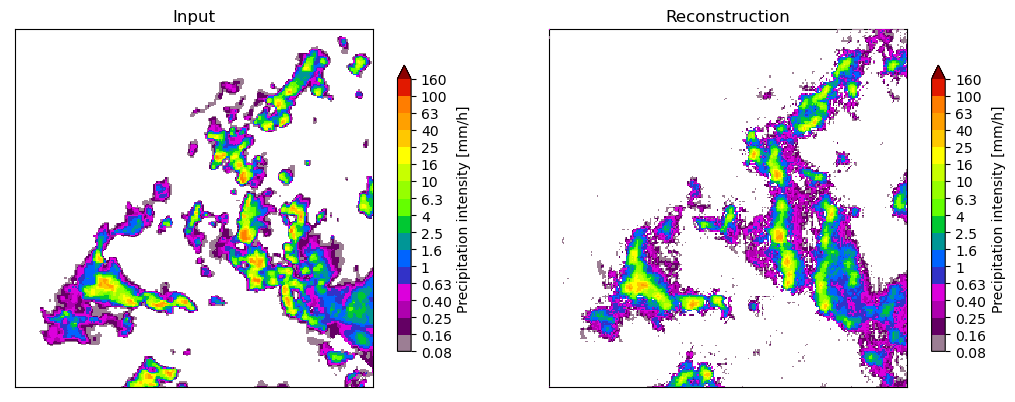

MSE: 11.672 MAE: 0.771 PCC: 0.684 
 CSI(1mm): 0.494 CSI(2mm): 0.458 CSI(8mm): 0.329 
 ACC(1mm): 0.929 ACC(2mm): 0.949 ACC(8mm): 0.976 
 FSS(1km): 0.942 FSS(10km): 0.925 FSS(20km): 0.886 FSS(30km): 0.735


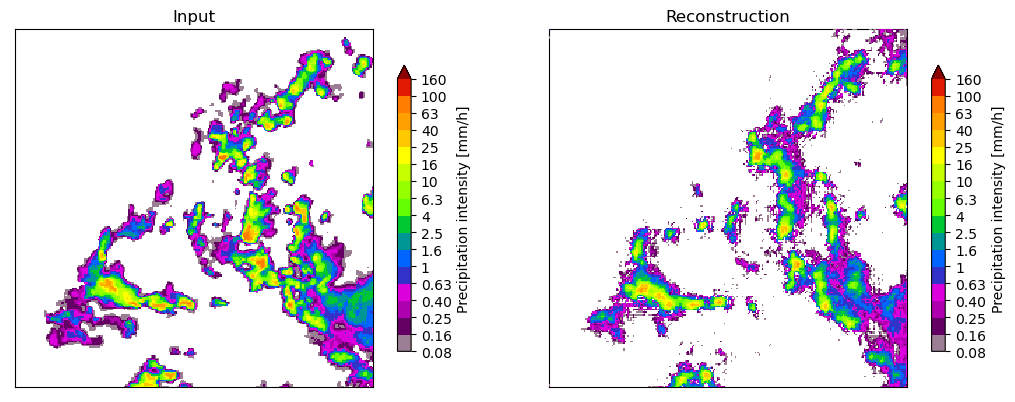

pcc_average: 0.6968


In [11]:
#torch.cuda.empty_cache()
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
device = 'cuda:1'
pcc_average = 0
tokenizer=tokenizer.to(device)
for i, images in enumerate(loaders['test']):
    if i<0:continue
    if i>=5:break

    
    checkpoint = torch.load('/space/ankushroy/Tokeniser_exp2_1024_embdim_8/vqvae_checkpoint_epoch50', map_location=device)
    tokenizer.load_state_dict(checkpoint['model_state_dict'])
    
    image = images[0]
    image = image.unsqueeze(1)
    image = image[4:5, :, :, :]
    input_image= image.to(device)  # batch x
        #print(input_image.size())
    a_r = tokenizer.encode_decode(input_image)
        #checkpoint = torch.load('/users/zboucher/iris/src/models/tokenizer/vqvae_epoch70', map_location = 'cpu')
        #vae.load_state_dict(checkpoint)
        #a_r2 = vae(a)

    for t in range(1):
        a_display = a_r[t,0,:,:].to('cpu').detach().numpy()*40
        a_r_display = input_image[t,0,:,:].to('cpu').detach().numpy()*40
        
        scores_cat1 = det_cat_fct(a_r_display, a_display, 1)
        scores_cat2 = det_cat_fct(a_r_display, a_display, 2)
        scores_cat8 = det_cat_fct(a_r_display, a_display, 8)
        scores_cont = det_cont_fct(a_r_display, a_display, thr=0.1)
        
        scores_spatial = intensity_scale(a_r_display, a_display, 'FSS', 0.1, [1,10,20,30])
        pcc_average += float(np.around(scores_cont['corr_p'],3))
        if True:
            print(  'MSE:', np.around(scores_cont['MSE'],3), 
                    'MAE:', np.around(scores_cont['MAE'],3), 
                    'PCC:', np.around(scores_cont['corr_p'],3),'\n', 
                    'CSI(1mm):', np.around(scores_cat1['CSI'],3), # CSI: TP/(TP+FP+FN)
                    'CSI(2mm):', np.around(scores_cat2['CSI'],3),
                    'CSI(8mm):', np.around(scores_cat8['CSI'],3),'\n',
                    'ACC(1mm):', np.around(scores_cat1['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
                    'ACC(2mm):', np.around(scores_cat2['ACC'],3),
                    'ACC(8mm):', np.around(scores_cat8['ACC'],3),'\n',
                    'FSS(1km):', np.around(scores_spatial[0][0],3),
                    'FSS(10km):', np.around(scores_spatial[1][0],3),
                    'FSS(20km):', np.around(scores_spatial[2][0],3),
                    'FSS(30km):', np.around(scores_spatial[3][0],3)
                    )  
            plt.figure(figsize=(16, 4))
            plt.subplot(131)
            plot_precip_field(a_r_display, title="Input")
            plt.subplot(132)
            plot_precip_field(a_display, title="Reconstruction")
            
            plt.tight_layout()
            plt.show()
print('pcc_average:', pcc_average/i)

In [10]:
print(input_image.shape)
print(images.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 9, 256, 256])


In [11]:
from torchsummary import summary
input_image_tuple = (1,256,256)
summary(encoder,input_image_tuple)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 256, 256]           1,280
         GroupNorm-2        [-1, 128, 256, 256]             256
            Conv2d-3        [-1, 128, 256, 256]         147,584
         GroupNorm-4        [-1, 128, 256, 256]             256
           Dropout-5        [-1, 128, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]         147,584
       ResnetBlock-7        [-1, 128, 256, 256]               0
         GroupNorm-8        [-1, 128, 256, 256]             256
            Conv2d-9        [-1, 128, 256, 256]         147,584
        GroupNorm-10        [-1, 128, 256, 256]             256
          Dropout-11        [-1, 128, 256, 256]               0
           Conv2d-12        [-1, 128, 256, 256]         147,584
      ResnetBlock-13        [-1, 128, 256, 256]               0
           Conv2d-14        [-1, 128, 1

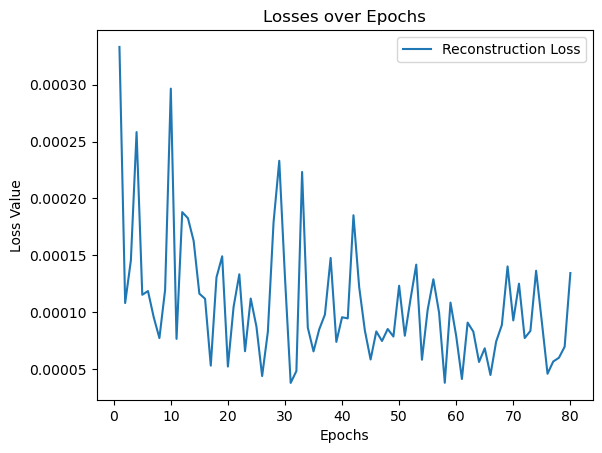

In [20]:
import numpy as np

# Load the NumPy array from file
array = np.load('/space/ankushroy/Tokeniser_exp2_1024_embdim_8/metrices.npy', allow_pickle=True)

import matplotlib.pyplot as plt

metrics = array  # List of 79 metrics dictionaries

# Create lists to store the loss values
total_losses = []
commitment_losses = []
reconstruction_losses = []
perceptual_losses = []

# Extract the loss values from each metrics dictionary
for metric in metrics:
    total_losses.append(metric["<class '__main__.Tokenizer'>/train/total_loss"])
    commitment_losses.append(metric["tokenizer/train/commitment_loss"])
    reconstruction_losses.append(metric["tokenizer/train/reconstruction_loss"])
    perceptual_losses.append(metric["tokenizer/train/perceptual_loss"])

# Plot the losses
epochs = range(1, len(metrics) + 1)

#plt.plot(epochs, total_losses, label='Total Loss')
#plt.plot(epochs, commitment_losses, label='Commitment Loss')
plt.plot(epochs, reconstruction_losses, label='Reconstruction Loss')
#plt.plot(epochs, perceptual_losses, label='Perceptual Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Losses over Epochs')
plt.legend()
plt.show()


In [21]:
print(reconstruction_losses)
print(len(reconstruction_losses))
print(reconstruction_losses[50:60])

[0.00033321333467029035, 0.00010792339162435383, 0.00014533291687257588, 0.0002582980669103563, 0.00011517989332787693, 0.00011843776883324608, 9.551208495395258e-05, 7.706340693403035e-05, 0.00011954514775425196, 0.0002965244057122618, 7.639243267476559e-05, 0.00018787461158353835, 0.00018251960864290595, 0.00016256645903922617, 0.00011617322161328048, 0.00011167074262630194, 5.285644147079438e-05, 0.00013047800166532397, 0.0001490096328780055, 5.204207627684809e-05, 0.0001046330580720678, 0.00013318812125362456, 6.553185812663287e-05, 0.00011188029020559043, 8.722866186872125e-05, 4.3684041884262115e-05, 8.257890294771641e-05, 0.0001788936206139624, 0.00023304350906983018, 0.00013048856635577977, 3.763839777093381e-05, 4.809813617612235e-05, 0.00022322656877804548, 8.628643990959972e-05, 6.538370507769287e-05, 8.475564391119406e-05, 9.778601815924048e-05, 0.00014758275938220322, 7.373739208560437e-05, 9.540880273561925e-05, 9.441534348297864e-05, 0.0001851467095548287, 0.000121977565

In [ ]:
#Training the Model from 50th checkpoint (to 60th epoch)
import numpy as np
from collections import defaultdict
checkpoint_path = '/space/ankushroy/Tokeniser_exp2_1024_embdim_8/vqvae_checkpoint_epoch50'
checkpoint = torch.load(checkpoint_path,map_location=device)
tokenizer.load_state_dict(checkpoint['model_state_dict'])
optimizer_tokenizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_total_step=0.0
intermediate_losses = defaultdict(float)

#device = torch.device("cuda:1")  # Specify the GPU device
tokenizer.to(device)

epoch_start=50
num_epochs=60

all_metrics = []  # List to store metrics for all epochs

for epoch in range(epoch_start,num_epochs):
    save_epoch = epoch in [51,52,53,54,55,56,57,58,59]
    
    loss_total_epoch=0.0
    optimizer_tokenizer.zero_grad()
    intermediate_losses = {}
    print("epoch {}".format(epoch))
    for i, images in enumerate(loaders['train']):
        loss_total_step=0.0
        image = images[0]
        image = image.unsqueeze(1)
        image = image[3:4, :, :, :]
        input_image= image.to(device)  # batch x
        #print(input_image.size())
        encoder_output = tokenizer.encode(input_image)
        losses=tokenizer.compute_loss(input_image)
        
        loss_total_step += losses.loss_total 
        loss_total_epoch += loss_total_step.item()/64
        if (i+1) % 64 == 0:
            (loss_total_step/64).backward()
            optimizer_tokenizer.step()
            optimizer_tokenizer.zero_grad()
            
            print("Losses: Total = {:.4f}".format(loss_total_step.item()))
            #loss_total_step=0.0
        

        for loss_name, loss_value in losses.intermediate_losses.items():
                intermediate_losses[f"{str(tokenizer)}/train/{loss_name}"] = loss_value/64
    
        
    metrics = {f'{str(Tokenizer)}/train/total_loss': loss_total_epoch, **intermediate_losses}
    print("Epoch {}: Total Loss = {:.4f}".format(epoch, metrics[f'{str(Tokenizer)}/train/total_loss']))

    if save_epoch:
        torch.save({
        'model_state_dict': tokenizer.state_dict(),
        'optimizer_state_dict': optimizer_tokenizer.state_dict(),
        }, '/space/ankushroy/Tokeniser_exp2_1024_embdim_9/vqvae_checkpoint_epoch{}'.format(epoch+1))

    all_metrics.append(metrics)  # Save metrics for the current epoch to the list


# Convert the metrics list to a NumPy array
metrics_array = np.array(all_metrics)

# Save the metrics array as a NumPy file
np.save('/space/ankushroy/Tokeniser_exp2_1024_embdim_9/metrices.npy', metrics_array)
# Print all errors from each epoch's metrics dictionary
# print(all_metrics)


epoch 50
Losses: Total = 0.0616
Losses: Total = 0.1023
Losses: Total = 0.0614
Losses: Total = 0.1599
Losses: Total = 0.0834
Losses: Total = 0.0921
Losses: Total = 0.0312
Losses: Total = 0.0628
Losses: Total = 0.1696
Losses: Total = 0.1020
Losses: Total = 0.0649
Losses: Total = 0.1453
Losses: Total = 0.1191
Losses: Total = 0.0890
Losses: Total = 0.0805
Losses: Total = 0.0093
Losses: Total = 0.0345
Losses: Total = 0.1103
Losses: Total = 0.1147
Losses: Total = 0.1225
Losses: Total = 0.0867
Losses: Total = 0.1217
Losses: Total = 0.0895
Losses: Total = 0.1223
Losses: Total = 0.0656
Losses: Total = 0.0591
Losses: Total = 0.0975
Losses: Total = 0.1170
Losses: Total = 0.0373
Losses: Total = 0.0714
Losses: Total = 0.0149
Losses: Total = 0.0982
Losses: Total = 0.0790
Losses: Total = 0.0522
Losses: Total = 0.0526
Losses: Total = 0.0904
Losses: Total = 0.0553
Losses: Total = 0.1149
Losses: Total = 0.1260
Losses: Total = 0.1075
Losses: Total = 0.1134
Losses: Total = 0.0769
Losses: Total = 0.0705
Lo

Losses: Total = 0.1347
Losses: Total = 0.1533
Losses: Total = 0.0873
Losses: Total = 0.0744
Losses: Total = 0.1518
Losses: Total = 0.1136
Losses: Total = 0.0679
Losses: Total = 0.1054
Losses: Total = 0.0265
Losses: Total = 0.1030
Losses: Total = 0.0283
Losses: Total = 0.0503
Losses: Total = 0.0572
Losses: Total = 0.1462
Losses: Total = 0.0972
Losses: Total = 0.1105
Losses: Total = 0.1089
Losses: Total = 0.0875
Losses: Total = 0.1163
Losses: Total = 0.0355
Losses: Total = 0.1048
Losses: Total = 0.1482
Losses: Total = 0.0857
Losses: Total = 0.0622
Losses: Total = 0.0513
Losses: Total = 0.0146
Losses: Total = 0.0509
Losses: Total = 0.0786
Losses: Total = 0.0838
Losses: Total = 0.0848
Losses: Total = 0.0847
Losses: Total = 0.0478
Losses: Total = 0.0932
Losses: Total = 0.0595
Losses: Total = 0.0570
Losses: Total = 0.0354
Losses: Total = 0.0781
Losses: Total = 0.0175
Losses: Total = 0.0700
Losses: Total = 0.0915
Losses: Total = 0.0849
Losses: Total = 0.0744
Losses: Total = 0.0580
Losses: Tot

Losses: Total = 0.0249
Losses: Total = 0.0445
Losses: Total = 0.0447
Losses: Total = 0.1547
Losses: Total = 0.0386
Losses: Total = 0.0658
Losses: Total = 0.0378
Losses: Total = 0.1798
Losses: Total = 0.0516
Losses: Total = 0.0869
Losses: Total = 0.1485
Losses: Total = 0.1563
Losses: Total = 0.0788
Losses: Total = 0.0513
Losses: Total = 0.1274
Losses: Total = 0.1544
Losses: Total = 0.0582
Losses: Total = 0.0780
Losses: Total = 0.0544
Losses: Total = 0.0500
Losses: Total = 0.1340
Losses: Total = 0.1415
Losses: Total = 0.0382
Losses: Total = 0.1511
Losses: Total = 0.2024
Losses: Total = 0.0792
Losses: Total = 0.0412
Losses: Total = 0.0662
Losses: Total = 0.0693
Losses: Total = 0.0935
Losses: Total = 0.0624
Losses: Total = 0.1035
Losses: Total = 0.1071
Losses: Total = 0.1082
Losses: Total = 0.1102
Losses: Total = 0.1095
Losses: Total = 0.1070
Losses: Total = 0.0838
Losses: Total = 0.0313
Losses: Total = 0.0770
Losses: Total = 0.0945
Losses: Total = 0.0248
Losses: Total = 0.0831
Losses: Tot

Losses: Total = 0.1895
Losses: Total = 0.0141
Losses: Total = 0.0611
Losses: Total = 0.0605
Losses: Total = 0.0402
Losses: Total = 0.0807
Losses: Total = 0.0695
Losses: Total = 0.0496
Losses: Total = 0.0796
Losses: Total = 0.0796
Losses: Total = 0.0372
Losses: Total = 0.0611
Losses: Total = 0.1465
Losses: Total = 0.0890
Losses: Total = 0.0558
Losses: Total = 0.0383
Losses: Total = 0.0443
Losses: Total = 0.1575
Losses: Total = 0.0826
Losses: Total = 0.0979
Losses: Total = 0.1658
Losses: Total = 0.0297
Losses: Total = 0.0243
Losses: Total = 0.1338
Losses: Total = 0.1460
Losses: Total = 0.0271
Losses: Total = 0.0887
Losses: Total = 0.2018
Losses: Total = 0.0178
Losses: Total = 0.0613
Losses: Total = 0.0993
Losses: Total = 0.0075
Losses: Total = 0.1001
Losses: Total = 0.0482
Losses: Total = 0.0729
Losses: Total = 0.0890
Losses: Total = 0.0617
Losses: Total = 0.1172
Losses: Total = 0.0915
Losses: Total = 0.0359
Losses: Total = 0.0732
Losses: Total = 0.0788
Losses: Total = 0.0236
Losses: Tot

Losses: Total = 0.1305
Losses: Total = 0.0951
Losses: Total = 0.1343
Losses: Total = 0.1004
Losses: Total = 0.0758
Losses: Total = 0.1262
Losses: Total = 0.1155
Losses: Total = 0.0469
Losses: Total = 0.1099
Losses: Total = 0.0320
Losses: Total = 0.0376
Epoch 52: Total Loss = 39.3234
epoch 53
Losses: Total = 0.0751
Losses: Total = 0.0699
Losses: Total = 0.0709
Losses: Total = 0.0586
Losses: Total = 0.0391
Losses: Total = 0.0763
Losses: Total = 0.0877
Losses: Total = 0.1431
Losses: Total = 0.0868
Losses: Total = 0.1298
Losses: Total = 0.0685
Losses: Total = 0.0908
Losses: Total = 0.0417
Losses: Total = 0.0595
Losses: Total = 0.0969
Losses: Total = 0.0748
Losses: Total = 0.0273
Losses: Total = 0.0762
Losses: Total = 0.0826
Losses: Total = 0.0933
Losses: Total = 0.0585
Losses: Total = 0.0188
Losses: Total = 0.0206
Losses: Total = 0.0957
Losses: Total = 0.1205
Losses: Total = 0.0267
Losses: Total = 0.0772
Losses: Total = 0.0803
Losses: Total = 0.1042
Losses: Total = 0.0770
Losses: Total = 0

Losses: Total = 0.0512
Losses: Total = 0.0249
Losses: Total = 0.0497
Losses: Total = 0.0777
Losses: Total = 0.0751
Losses: Total = 0.0575
Losses: Total = 0.0638
Losses: Total = 0.0451
Losses: Total = 0.0411
Losses: Total = 0.0775
Losses: Total = 0.0762
Losses: Total = 0.0490
Losses: Total = 0.1184
Losses: Total = 0.0273
Losses: Total = 0.1350
Losses: Total = 0.1221
Losses: Total = 0.1494
Losses: Total = 0.0792
Losses: Total = 0.0630
Losses: Total = 0.0686
Losses: Total = 0.0965
Losses: Total = 0.2074
Losses: Total = 0.0698
Losses: Total = 0.1839
Losses: Total = 0.0424
Losses: Total = 0.0359
Losses: Total = 0.1102
Losses: Total = 0.1424
Losses: Total = 0.1121
Losses: Total = 0.0692
Losses: Total = 0.0991
Losses: Total = 0.0515
Losses: Total = 0.0454
Losses: Total = 0.0969
Losses: Total = 0.1679
Losses: Total = 0.1006
Losses: Total = 0.0859
Losses: Total = 0.0349
Losses: Total = 0.0760
Losses: Total = 0.1180
Losses: Total = 0.1123
Losses: Total = 0.0749
Losses: Total = 0.1062
Losses: Tot

Losses: Total = 0.0585
Losses: Total = 0.0786
Losses: Total = 0.0769
Losses: Total = 0.0584
Losses: Total = 0.0672
Losses: Total = 0.0995
Losses: Total = 0.0557
Losses: Total = 0.0189
Losses: Total = 0.1284
Losses: Total = 0.0446
Losses: Total = 0.0552
Losses: Total = 0.0304
Losses: Total = 0.0548
Losses: Total = 0.0433
Losses: Total = 0.0238
Losses: Total = 0.0593
Losses: Total = 0.0912
Losses: Total = 0.0333
Losses: Total = 0.1263
Losses: Total = 0.1634
Losses: Total = 0.1362
Losses: Total = 0.1750
Losses: Total = 0.0697
Losses: Total = 0.0760
Losses: Total = 0.0752
Losses: Total = 0.1450
Losses: Total = 0.1043
Losses: Total = 0.0986
Losses: Total = 0.0451
Losses: Total = 0.0182
Losses: Total = 0.1188
Losses: Total = 0.0735
Losses: Total = 0.0586
Losses: Total = 0.0899
Losses: Total = 0.1633
Losses: Total = 0.0620
Losses: Total = 0.0912
Losses: Total = 0.0781
Losses: Total = 0.1187
Losses: Total = 0.0753
Losses: Total = 0.0723
Losses: Total = 0.0563
Losses: Total = 0.1208
Losses: Tot

Losses: Total = 0.0644
Losses: Total = 0.0875
Losses: Total = 0.1179
Losses: Total = 0.0968
Losses: Total = 0.0539
Losses: Total = 0.0663
Losses: Total = 0.0888
Losses: Total = 0.0877
Losses: Total = 0.0977
Losses: Total = 0.0947
Losses: Total = 0.1177
Losses: Total = 0.0802
Losses: Total = 0.0913
Losses: Total = 0.0627
Losses: Total = 0.1364
Losses: Total = 0.0976
Losses: Total = 0.0243
Losses: Total = 0.0784
Losses: Total = 0.0615
Losses: Total = 0.0965
Losses: Total = 0.1235
Losses: Total = 0.0868
Losses: Total = 0.0904
Losses: Total = 0.0409
Losses: Total = 0.1063
Losses: Total = 0.1162
Losses: Total = 0.0886
Losses: Total = 0.0433
Losses: Total = 0.1019
Losses: Total = 0.0950
Losses: Total = 0.1175
Losses: Total = 0.0877
Losses: Total = 0.0203
Losses: Total = 0.0757
Losses: Total = 0.0321
Losses: Total = 0.0853
Losses: Total = 0.0384
Losses: Total = 0.0786
Losses: Total = 0.0940
Losses: Total = 0.0864
Losses: Total = 0.0187
Losses: Total = 0.0420
Losses: Total = 0.1258
Losses: Tot

Losses: Total = 0.0529
Losses: Total = 0.0649
Losses: Total = 0.0859
Losses: Total = 0.0790
Losses: Total = 0.0857
Losses: Total = 0.0902
Losses: Total = 0.1217
Losses: Total = 0.0823
Losses: Total = 0.0931
Losses: Total = 0.0542
Losses: Total = 0.0551
Losses: Total = 0.0587
Losses: Total = 0.1287
Losses: Total = 0.0294
Losses: Total = 0.1147
Losses: Total = 0.0672
Losses: Total = 0.0117
Losses: Total = 0.1266
Losses: Total = 0.0774
Losses: Total = 0.0999
Losses: Total = 0.1332
Losses: Total = 0.0925
Losses: Total = 0.0161
Epoch 55: Total Loss = 38.4708
epoch 56
Losses: Total = 0.0823
Losses: Total = 0.0103
Losses: Total = 0.0646
Losses: Total = 0.2161
Losses: Total = 0.0633
Losses: Total = 0.0736
Losses: Total = 0.0869
Losses: Total = 0.0921
Losses: Total = 0.0458
Losses: Total = 0.0680
Losses: Total = 0.1020
Losses: Total = 0.0959
Losses: Total = 0.1491
Losses: Total = 0.0999
Losses: Total = 0.1104
Losses: Total = 0.1342
Losses: Total = 0.1205
Losses: Total = 0.1554
Losses: Total = 0

Losses: Total = 0.0692
Losses: Total = 0.0988
Losses: Total = 0.1001
Losses: Total = 0.0060
Losses: Total = 0.0670
Losses: Total = 0.0646
Losses: Total = 0.0446
Losses: Total = 0.0418
Losses: Total = 0.0522
Losses: Total = 0.0900
Losses: Total = 0.0227
Losses: Total = 0.0433
Losses: Total = 0.0503
Losses: Total = 0.0365
Losses: Total = 0.0437
Losses: Total = 0.1064
